# **Generative Adversarial Network**

Reference: I.J. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville and Y. Bengio, <br/> 
"Generative Adversarial Networks,” arXiv preprint 2014.


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Image directory
dir_image = '/content/gdrive/My Drive/Colab Notebooks/3_GANs/pic'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**Set parameters**

In [24]:
dim_z = 100

###**Set training parameters**

In [25]:
# Parameters
batch_size = 128
train_buf = 60000
test_buf = 10000 

training_epochs = 100

display_step = 10

###**Load MNIST data**
Set train & test data

In [26]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0
x_train = (x_train - 0.5) * 2.0
x_test = (x_test - 0.5) * 2.0

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(train_buf)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(test_buf)
    .batch(batch_size)
)

In [27]:
dim_x = np.shape(x_train)[1:]
dim_x_prod = reduce( (lambda x, y: x * y), dim_x)

###**Set model**


In [28]:
class GAN(keras.Model):
  """ A basic gan class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(GAN, self).__init__()
    self.__dict__.update(kwargs)

    # Set network
    self.gen_nn = keras.Sequential(self.gen_desc)
    self.disc_nn = keras.Sequential(self.disc_desc)

  def generate(self, z):
      return self.gen_nn(z)

  def discriminate(self, x):
      return self.disc_nn(x)

  @tf.function
  def compute_loss(self, x):
    # Generating noise from a uniform distribution
    z_samp = tf.random.normal([x.shape[0], self.dim_z])

    # Run noise through generator
    x_gen = self.generate(z_samp)
    
    # Discriminate x and x_gen
    logits_x = self.discriminate(x)
    logits_x_gen = self.discriminate(x_gen)
    
    # Set losses
    # Losses of real with label "1"
    disc_real_loss = self.gan_loss(logits=logits_x, is_real=True)
    # Losses of fake with label "0"
    disc_fake_loss = self.gan_loss(logits=logits_x_gen, is_real=False)
    disc_loss = disc_fake_loss + disc_real_loss

    # Losses of fake with label "1"
    gen_loss = self.gan_loss(logits=logits_x_gen, is_real=True)

    return gen_loss, disc_loss
  
  @staticmethod
  def gan_loss(logits, is_real=True):
    """ Computes standard gan loss between logits and labels. """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    loss_out = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    return loss_out

  def compute_gradients(self, x):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_loss, disc_loss = self.compute_loss(x)
    
    # Compute gradients
    gen_gradients = gen_tape.gradient(gen_loss, self.gen_nn.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, self.disc_nn.trainable_variables)

    return gen_gradients, disc_gradients, gen_loss, disc_loss

  def apply_gradients(self, gen_gradients, disc_gradients):
    self.gen_optimizer.apply_gradients(
        zip(gen_gradients, self.gen_nn.trainable_variables))
    self.disc_optimizer.apply_gradients(
        zip(disc_gradients, self.disc_nn.trainable_variables))
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    gen_gradients, disc_gradients, gen_loss, disc_loss = self.compute_gradients(x)
    self.apply_gradients(gen_gradients, disc_gradients)

    return gen_loss, disc_loss

In [29]:
gen_desc = [
  keras.layers.InputLayer(input_shape=dim_z),
  keras.layers.Dense(units=256, activation="LeakyReLU"),
  keras.layers.Dense(units=512, activation="LeakyReLU"),
  keras.layers.Dense(units=512, activation="LeakyReLU"),
  keras.layers.Dense(units=dim_x_prod, activation="tanh"),
  keras.layers.Reshape(target_shape=dim_x)
]

disc_desc = [
    keras.layers.InputLayer(input_shape=dim_x),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="LeakyReLU"),
    keras.layers.Dense(units=256, activation="LeakyReLU"),
    keras.layers.Dense(units=1)
]

# Set optimizers
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)

In [30]:
gan = GAN(dim_z=dim_z, gen_desc=gen_desc, disc_desc=disc_desc, 
          gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

### Train model

In [31]:
# Test-data for plot
import matplotlib.pyplot as plt

def plot_reconstruction(model, nex=8, zm=2, epoch=0):
  samples = model.generate(tf.random.normal(shape=(nex, dim_z)))
  fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
  for axi in range(nex):
    axs[axi].matshow(
        samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=-1, vmax=1)
    axs[axi].axis('off')
  plt.show()

  # Save fig
  figname2save = '{:s}/gan_mnist_z{:d}_b{:d}_e{:d}.png'.format(dir_image, dim_z, batch_size, epoch)
  fig.savefig(figname2save)

In [32]:
# Select metrics to measure the loss of the model
train_gen_loss = keras.metrics.Mean(name='train_gen_loss')
train_disc_loss = keras.metrics.Mean(name='train_disc_loss')
test_gen_loss = keras.metrics.Mean(name='test_gen_loss')
test_disc_loss = keras.metrics.Mean(name='test_disc_loss')

Epoch 1, Train-Loss: [0.8762,0.9897], Test-Loss: [0.8359,0.9157]


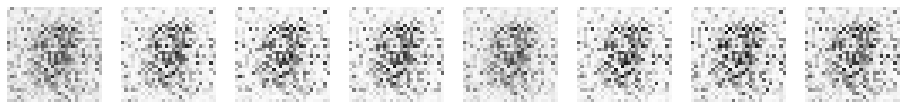

Epoch 2, Train-Loss: [1.0839,0.8581], Test-Loss: [1.2154,0.6922]
Epoch 3, Train-Loss: [1.2473,0.8424], Test-Loss: [1.2271,0.6279]
Epoch 4, Train-Loss: [1.4354,0.7605], Test-Loss: [1.7952,0.6335]
Epoch 5, Train-Loss: [1.3728,0.8239], Test-Loss: [1.2977,0.8099]
Epoch 6, Train-Loss: [1.3582,0.8599], Test-Loss: [1.5152,0.7755]
Epoch 7, Train-Loss: [1.3584,0.8843], Test-Loss: [2.0250,0.7504]
Epoch 8, Train-Loss: [1.4220,0.8605], Test-Loss: [1.0175,0.7604]
Epoch 9, Train-Loss: [1.3889,0.8404], Test-Loss: [1.3559,0.7745]
Epoch 10, Train-Loss: [1.4044,0.8501], Test-Loss: [1.7573,0.8103]
Epoch 11, Train-Loss: [1.4003,0.8667], Test-Loss: [1.2540,0.7481]


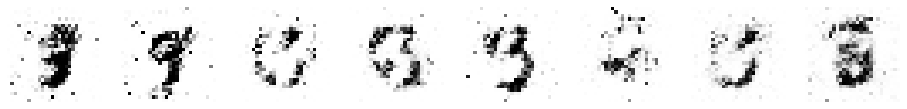

Epoch 12, Train-Loss: [1.4552,0.8227], Test-Loss: [1.6667,0.7401]
Epoch 13, Train-Loss: [1.4150,0.8667], Test-Loss: [1.2628,0.8739]
Epoch 14, Train-Loss: [1.4039,0.8749], Test-Loss: [1.5753,0.8265]
Epoch 15, Train-Loss: [1.3330,0.9424], Test-Loss: [1.5189,0.9633]
Epoch 16, Train-Loss: [1.2327,1.0110], Test-Loss: [1.3308,1.0092]
Epoch 17, Train-Loss: [1.1534,1.0501], Test-Loss: [1.0862,1.0595]
Epoch 18, Train-Loss: [1.0978,1.0933], Test-Loss: [1.2955,1.0107]
Epoch 19, Train-Loss: [1.0997,1.0926], Test-Loss: [1.0995,1.0523]
Epoch 20, Train-Loss: [1.0786,1.1027], Test-Loss: [1.0185,1.0751]
Epoch 21, Train-Loss: [1.0714,1.1120], Test-Loss: [1.1298,1.1114]


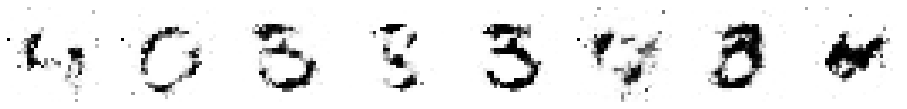

Epoch 22, Train-Loss: [1.0610,1.1230], Test-Loss: [1.0014,1.0935]
Epoch 23, Train-Loss: [1.0551,1.1269], Test-Loss: [1.1196,1.0656]
Epoch 24, Train-Loss: [1.0595,1.1249], Test-Loss: [1.1517,1.0610]
Epoch 25, Train-Loss: [1.0513,1.1283], Test-Loss: [1.1395,1.0768]
Epoch 26, Train-Loss: [1.0655,1.1269], Test-Loss: [0.8599,1.0883]
Epoch 27, Train-Loss: [1.0573,1.1293], Test-Loss: [1.1534,1.1081]
Epoch 28, Train-Loss: [1.0552,1.1298], Test-Loss: [0.9161,1.0751]
Epoch 29, Train-Loss: [1.0555,1.1325], Test-Loss: [1.0349,1.1103]
Epoch 30, Train-Loss: [1.0529,1.1358], Test-Loss: [0.9020,1.1193]
Epoch 31, Train-Loss: [1.0553,1.1356], Test-Loss: [0.8341,1.1635]


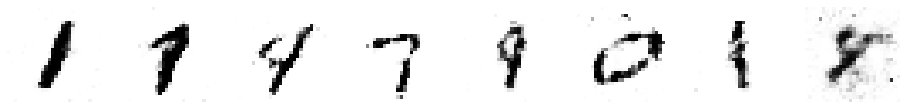

Epoch 32, Train-Loss: [1.0535,1.1360], Test-Loss: [1.1762,1.0625]
Epoch 33, Train-Loss: [1.0453,1.1465], Test-Loss: [1.0160,1.1315]
Epoch 34, Train-Loss: [1.0420,1.1487], Test-Loss: [0.9443,1.1617]
Epoch 35, Train-Loss: [1.0519,1.1453], Test-Loss: [0.9949,1.1786]
Epoch 36, Train-Loss: [1.0442,1.1477], Test-Loss: [0.8775,1.1530]
Epoch 37, Train-Loss: [1.0428,1.1468], Test-Loss: [0.9537,1.1801]
Epoch 38, Train-Loss: [1.0333,1.1569], Test-Loss: [0.9854,1.1263]
Epoch 39, Train-Loss: [1.0343,1.1579], Test-Loss: [1.0001,1.1803]
Epoch 40, Train-Loss: [1.0441,1.1542], Test-Loss: [1.0293,1.1654]
Epoch 41, Train-Loss: [1.0365,1.1580], Test-Loss: [0.9972,1.1717]


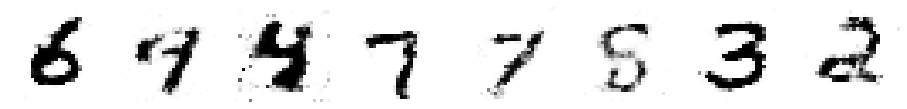

Epoch 42, Train-Loss: [1.0374,1.1575], Test-Loss: [0.8827,1.2459]
Epoch 43, Train-Loss: [1.0407,1.1550], Test-Loss: [1.0573,1.2034]
Epoch 44, Train-Loss: [1.0429,1.1609], Test-Loss: [1.0825,1.1700]
Epoch 45, Train-Loss: [1.0364,1.1561], Test-Loss: [0.9562,1.1745]
Epoch 46, Train-Loss: [1.0378,1.1592], Test-Loss: [0.8510,1.2139]
Epoch 47, Train-Loss: [1.0357,1.1615], Test-Loss: [1.1171,1.1766]
Epoch 48, Train-Loss: [1.0504,1.1552], Test-Loss: [1.0009,1.1875]
Epoch 49, Train-Loss: [1.0459,1.1568], Test-Loss: [1.0800,1.1826]
Epoch 50, Train-Loss: [1.0457,1.1515], Test-Loss: [0.9564,1.2007]
Epoch 51, Train-Loss: [1.0410,1.1604], Test-Loss: [1.2386,1.1310]


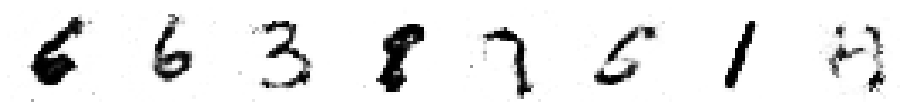

Epoch 52, Train-Loss: [1.0430,1.1583], Test-Loss: [0.9942,1.1791]
Epoch 53, Train-Loss: [1.0518,1.1590], Test-Loss: [0.9391,1.1512]
Epoch 54, Train-Loss: [1.0405,1.1593], Test-Loss: [0.9891,1.1733]
Epoch 55, Train-Loss: [1.0498,1.1586], Test-Loss: [1.1819,1.1860]
Epoch 56, Train-Loss: [1.0488,1.1556], Test-Loss: [0.9239,1.1357]
Epoch 57, Train-Loss: [1.0500,1.1559], Test-Loss: [1.2517,1.1714]
Epoch 58, Train-Loss: [1.0550,1.1561], Test-Loss: [1.1166,1.1730]
Epoch 59, Train-Loss: [1.0541,1.1551], Test-Loss: [1.1176,1.2466]
Epoch 60, Train-Loss: [1.0519,1.1563], Test-Loss: [0.9878,1.1734]
Epoch 61, Train-Loss: [1.0538,1.1605], Test-Loss: [1.0038,1.2702]


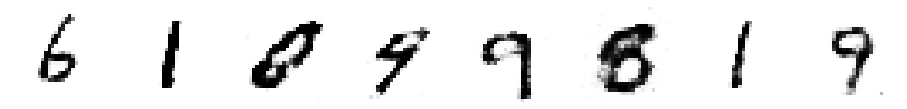

Epoch 62, Train-Loss: [1.0535,1.1596], Test-Loss: [0.9617,1.2033]
Epoch 63, Train-Loss: [1.0540,1.1522], Test-Loss: [0.9337,1.2282]
Epoch 64, Train-Loss: [1.0571,1.1525], Test-Loss: [1.2156,1.2265]
Epoch 65, Train-Loss: [1.0583,1.1523], Test-Loss: [0.9897,1.1782]
Epoch 66, Train-Loss: [1.0589,1.1560], Test-Loss: [0.9762,1.1534]
Epoch 67, Train-Loss: [1.0530,1.1519], Test-Loss: [1.1078,1.2123]
Epoch 68, Train-Loss: [1.0605,1.1525], Test-Loss: [0.9223,1.2121]
Epoch 69, Train-Loss: [1.0657,1.1510], Test-Loss: [1.0930,1.2665]
Epoch 70, Train-Loss: [1.0616,1.1496], Test-Loss: [0.9005,1.1685]
Epoch 71, Train-Loss: [1.0671,1.1509], Test-Loss: [1.1863,1.2205]


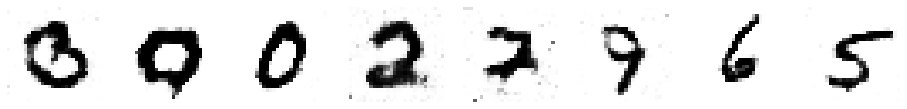

Epoch 72, Train-Loss: [1.0663,1.1505], Test-Loss: [0.9402,1.1790]
Epoch 73, Train-Loss: [1.0713,1.1449], Test-Loss: [1.1161,1.1842]
Epoch 74, Train-Loss: [1.0684,1.1486], Test-Loss: [0.9342,1.1536]
Epoch 75, Train-Loss: [1.0675,1.1498], Test-Loss: [1.0025,1.1852]
Epoch 76, Train-Loss: [1.0686,1.1470], Test-Loss: [0.9119,1.2118]
Epoch 77, Train-Loss: [1.0733,1.1463], Test-Loss: [1.0665,1.2441]
Epoch 78, Train-Loss: [1.0739,1.1463], Test-Loss: [1.0963,1.2096]
Epoch 79, Train-Loss: [1.0732,1.1455], Test-Loss: [1.0725,1.2401]
Epoch 80, Train-Loss: [1.0770,1.1429], Test-Loss: [1.0410,1.1813]
Epoch 81, Train-Loss: [1.0749,1.1465], Test-Loss: [0.9400,1.2026]


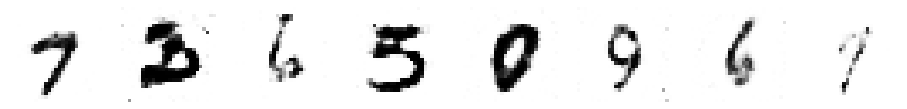

Epoch 82, Train-Loss: [1.0761,1.1441], Test-Loss: [0.9867,1.1961]
Epoch 83, Train-Loss: [1.0784,1.1424], Test-Loss: [1.2075,1.1801]
Epoch 84, Train-Loss: [1.0792,1.1438], Test-Loss: [0.9879,1.2008]
Epoch 85, Train-Loss: [1.0787,1.1470], Test-Loss: [1.4493,1.2545]
Epoch 86, Train-Loss: [1.0823,1.1451], Test-Loss: [1.1375,1.2284]
Epoch 87, Train-Loss: [1.0809,1.1468], Test-Loss: [1.0661,1.1984]
Epoch 88, Train-Loss: [1.0788,1.1426], Test-Loss: [1.1813,1.1779]
Epoch 89, Train-Loss: [1.0822,1.1428], Test-Loss: [1.1421,1.2300]
Epoch 90, Train-Loss: [1.0889,1.1389], Test-Loss: [0.8789,1.2283]
Epoch 91, Train-Loss: [1.0897,1.1380], Test-Loss: [1.1311,1.1929]


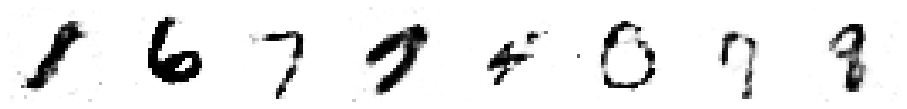

Epoch 92, Train-Loss: [1.0872,1.1398], Test-Loss: [1.1204,1.2246]
Epoch 93, Train-Loss: [1.0887,1.1418], Test-Loss: [1.1599,1.2426]
Epoch 94, Train-Loss: [1.0883,1.1383], Test-Loss: [1.1611,1.1615]
Epoch 95, Train-Loss: [1.0962,1.1366], Test-Loss: [0.9925,1.2019]
Epoch 96, Train-Loss: [1.0917,1.1363], Test-Loss: [1.0534,1.2139]
Epoch 97, Train-Loss: [1.0941,1.1387], Test-Loss: [0.9623,1.1994]
Epoch 98, Train-Loss: [1.1000,1.1371], Test-Loss: [1.2025,1.1783]
Epoch 99, Train-Loss: [1.0934,1.1362], Test-Loss: [1.0559,1.1799]
Epoch 100, Train-Loss: [1.0937,1.1408], Test-Loss: [1.1848,1.2303]


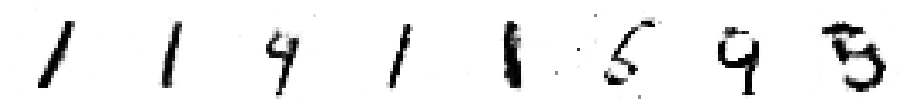

In [ ]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    gen_loss, disc_loss = gan.train(x_batch)
    train_gen_loss(gen_loss)
    train_disc_loss(disc_loss)

  for x_batch_t in test_data:
    gen_loss_t, disc_loss_t = gan.compute_loss(x_batch_t)
    test_gen_loss(gen_loss_t)
    test_disc_loss(disc_loss_t)

  txt_template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(txt_template.format(epoch+1, train_gen_loss.result(), 
                            train_disc_loss.result(), test_gen_loss.result(),
                            test_disc_loss.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_reconstruction(gan, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_gen_loss.reset_states()
  train_disc_loss.reset_states()
  test_gen_loss.reset_states()
  test_disc_loss.reset_states()